# Model Evaluation
- Quick Start: https://docs.deepchecks.com/stable/tabular/auto_tutorials/quickstarts/plot_quick_model_evaluation.html
- Gallery: https://docs.deepchecks.com/stable/tabular/auto_checks/model_evaluation/index.html

In [1]:
#import mercury as mr
import pandas as pd
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import model_evaluation

In [2]:
!ls data

TitanicData2.csv         TitanicData2_dcTest.csv  TitanicData2_dcTrain.csv


In [3]:
df_train = pd.read_csv('data/TitanicData2_dcTrain.csv')
df_test = pd.read_csv('data/TitanicData2_dcTest.csv')
print(df_train.shape, df_test.shape)
df_train.head()

(1047, 8) (262, 8)


,Passenger_Id,pclass,sex,age,sibsp,parch,fare,survived
0,648,3rd,female,22.0,0,0,7.7500,1
1,391,3rd,male,16.0,1,3,34.3750,0
2,351,1st,female,49.0,1,0,76.7292,1
3,1163,3rd,female,24.0,0,0,7.7500,0
4,105,3rd,female,18.0,0,0,9.8417,1


In [4]:
df_train.dtypes

Passenger_Id      int64
pclass           object
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
survived          int64
dtype: object

## Model Training

In [5]:
# カテゴリカルカラムをcategory型に変換
df_train['pclass'] = df_train['pclass'].astype('category')
df_train['sex'] = df_train['sex'].astype('category')
df_test['pclass'] = df_test['pclass'].astype('category')
df_test['sex'] = df_test['sex'].astype('category')

In [6]:
''' xgbを利用する場合
# DMatrixに変換し、enable_categorical=True を指定
dtrain = xgb.DMatrix(df_train[['pclass','sex','age','sibsp','parch','fare']], 
                     label=df_train['survived'], 
                     enable_categorical=True)
dtest = xgb.DMatrix(df_test[['pclass','sex','age','sibsp','parch','fare']], 
                    label=df_test['survived'], 
                    enable_categorical=True)

# ハイパーパラメータ設定
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'seed': 123
}

# モデルの訓練
model = xgb.train(params, dtrain)

# ハイパーパラメータ設定
mr.JSON(model.save_config())

# 予測
train_pred = model.predict(dtrain)
test_pred = model.predict(dtest)
train_pred.shape, test_pred.shape
'''

" xgbを利用する場合\n# DMatrixに変換し、enable_categorical=True を指定\ndtrain = xgb.DMatrix(df_train[['pclass','sex','age','sibsp','parch','fare']], \n                     label=df_train['survived'], \n                     enable_categorical=True)\ndtest = xgb.DMatrix(df_test[['pclass','sex','age','sibsp','parch','fare']], \n                    label=df_test['survived'], \n                    enable_categorical=True)\n\n# ハイパーパラメータ設定\nparams = {\n    'objective': 'binary:logistic',\n    'max_depth': 3,\n    'seed': 123\n}\n\n# モデルの訓練\nmodel = xgb.train(params, dtrain)\n\n# ハイパーパラメータ設定\nmr.JSON(model.save_config())\n\n# 予測\ntrain_pred = model.predict(dtrain)\ntest_pred = model.predict(dtest)\ntrain_pred.shape, test_pred.shape\n"

In [7]:
m = XGBClassifier(objective='binary:logistic',
                  #max_depth=2, 
                  #n_estimators=50,
                  enable_categorical=True,
                  random_state=123)

In [8]:
m.fit(df_train[['pclass','sex','age','sibsp','parch','fare']], df_train['survived'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [9]:
# 予測
train_pred = m.predict_proba(df_train[['pclass','sex','age','sibsp','parch','fare']])
test_pred = m.predict_proba(df_test[['pclass','sex','age','sibsp','parch','fare']])
train_pred.shape, test_pred.shape

((1047, 2), (262, 2))

In [10]:
train_logloss = log_loss(df_train['survived'], train_pred[:,1])
test_logloss = log_loss(df_test['survived'], test_pred[:,1])
train_auc = roc_auc_score(df_train['survived'], train_pred[:,1])
test_auc = roc_auc_score(df_test['survived'], test_pred[:,1])

pd.DataFrame({'data':['Train', 'Test'], 'Logloss':[train_logloss, test_logloss], 'AUC of ROC':[train_auc, test_auc]})

,data,Logloss,AUC of ROC
0,Train,0.163614,0.989030
1,Test,0.541874,0.837407


In [11]:
# feature_importances_で特徴量重要度を取得
importances = m.feature_importances_
feature_names = ['pclass','sex','age','sibsp','parch','fare']

# カスタムで可視化
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
1,sex,0.661412
0,pclass,0.182024
3,sibsp,0.059953
5,fare,0.035654
2,age,0.031875
4,parch,0.029082


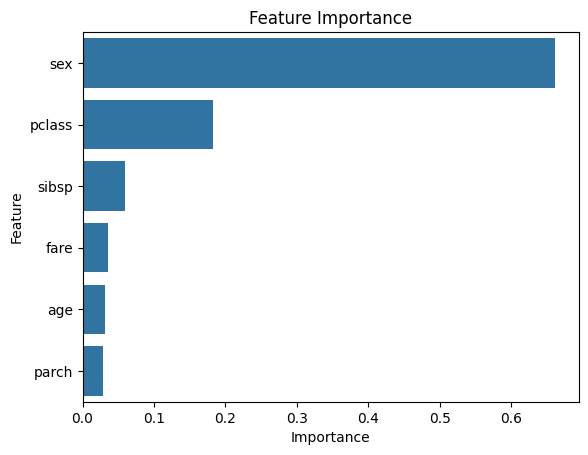

In [12]:
# 特徴量重要度のプロット
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()

## Model Evaluation

In [13]:
df_train.columns

Index(['Passenger_Id', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'survived'],
      dtype='object')

In [14]:
ds_train = Dataset(df_train[['pclass','sex','age','sibsp','parch','fare','survived']],
                   label='survived',
                   cat_features=['pclass','sex'])
ds_test = Dataset(df_test[['pclass','sex','age','sibsp','parch','fare','survived']],
                  label='survived',
                  cat_features=['pclass','sex'])

In [15]:
evaluation_suite = model_evaluation()
suite_result = evaluation_suite.run(ds_train, ds_test, m)

In [16]:
suite_result.show()

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_ZEFDKEA5ZEYLOTOM76CTFOO87">Model Evaluation S…

In [17]:
# 結果をhtml保存
suite_result.save_as_html('outputs/ModelEvaluation.html')

# to see the result access to the html file

'outputs/ModelEvaluation.html'

### Train Test Performance
https://docs.deepchecks.com/0.17/tabular/auto_checks/model_evaluation/plot_train_test_performance.html
- 学習データとテストデータに対するパフォーマンスに差がある

### Weak Segments Performance - Test Dataset
https://docs.deepchecks.com/0.17/tabular/auto_checks/model_evaluation/plot_weak_segments_performance.html
- テストデータにおいて、予測精度が全体と比べて悪いセグメントがある

In [18]:
# 0/1予測
#train_pred_binary = m.predict(df_train[['pclass','sex','age','sibsp','parch','fare']])
test_pred_binary = m.predict(df_test[['pclass','sex','age','sibsp','parch','fare']])

In [19]:
df_test['age'].describe()

count    214.000000
mean      29.720794
std       13.609353
min        0.416700
25%       22.000000
50%       29.000000
75%       36.875000
max       70.000000
Name: age, dtype: float64

In [20]:
print('N of test data: {},  N of missing in age column: {}'.format(df_test['age'].shape[0], df_test['age'].isna().sum()))

N of test data: 262,  N of missing in age column: 48


In [21]:
df_test['pred'] = test_pred_binary

In [22]:
df_test.head()

,Passenger_Id,pclass,sex,age,sibsp,parch,fare,survived,pred
0,1298,1st,male,17.0,0,2,110.8833,1,0
1,575,1st,female,45.0,0,1,59.4000,1,1
2,328,3rd,male,20.0,0,0,7.8542,0,0
3,408,3rd,male,25.0,0,0,7.0500,0,0
4,844,1st,male,NaN,0,0,35.5000,1,0


In [23]:
# 全体でのAccuracy
accuracy_score(df_test['survived'], df_test['pred'])

0.767175572519084

In [24]:
# Deepchecks:Weak Segmentsが示した予測が悪いセグメント。"35.5 <= age < 38.25"
df_test_ageSegment = df_test[(35.5 <= df_test['age']) & (df_test['age'] < 38.25)]
df_test_ageSegment

,Passenger_Id,pclass,sex,age,sibsp,parch,fare,survived,pred
10,805,3rd,male,36.5,1,0,17.4000,1,0
55,1008,3rd,male,37.0,2,0,7.9250,0,0
69,721,3rd,female,38.0,0,0,7.2292,1,0
72,679,1st,male,38.0,0,1,153.4625,0,0
88,1095,1st,male,36.0,1,2,120.0000,1,0
98,597,3rd,male,36.0,0,0,9.5000,0,0
120,475,3rd,female,38.0,4,2,7.7750,0,0
132,495,1st,male,37.0,1,0,53.1000,0,1
135,203,3rd,male,36.0,0,0,7.2500,0,0
176,1161,3rd,female,36.0,0,2,12.1833,0,1


In [25]:
accuracy_score(df_test_ageSegment['survived'], df_test_ageSegment['pred'])

0.5